In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

import package_LAB
from package_LAB import LeadLag_RT, PID_RT, IMCTuning

from importlib import reload
package_DBR = reload(package_DBR)
package_LAB = reload(package_LAB)

# Process constants

In [47]:
#SOPDT from PV
Kp = 0.398981565560627
T1p = 165.56685644081972
T2p = 3.645364787323084e-05
thetap = 0.6102455489040157

In [48]:
# from DV
Kd = 0.31148119513939204
T1d = 167.0472401651847
T2d = 14.406792795634894
thetad = 9.375122302137418



# Simulation constants

In [49]:
TSim = 1991
Ts = 1
N = int(TSim/Ts) + 1

MVPath = {0: 1, 1230: 0, TSim: 1}

In [50]:
# Working point
MV0 = 70
DV0 = 50
PV0 = 55

In [51]:
gamma = 0.6 # Lower = more aggressive
Kc,Ti,Td = IMCTuning(Kp,T1,T2,theta,gamma,'SOPDT')

In [52]:
alpha = 0.18
MVMin = 0
MVMax = 100

# Input signals 

In [57]:
settings = 'ManFF' 
if settings == 'Man':
    #  OLP + no FF
    ManPath = {0: True, 1000: False, 1500: True, TSim: True} # Path for Man
    MVManPath = {0: MV0, TSim: MV0} # Path for MVMan
    SPPath = {0: PV0, TSim: MV0} # Path for SP, always the same in most cases
    DVPath = {0: 50.0, 800: 60, TSim: 60.0} # Path for DV
    ActivateFF = False
    ManFF = True
    Title_loop = "Open-loop"
    Title_FF = "no feedforward"
    
elif settings == 'ManFF':
    # OLP + FF
    ManPath = {0: True, 1000: False, 1500: True, TSim: True} # Path for Man
    MVManPath = {0: MV0, TSim: MV0} # Path for MVMan
    SPPath = {0: PV0, TSim: MV0} # Path for SP, always the same in most cases
    DVPath = {0: 50.0, 800: 60, TSim: 60.0} # Path for DV
    ActivateFF = True
    ManFF = True
    Title_loop = "Open-loop"
    Title_FF = "feedforward"

elif settings == 'FF':
    # FF, CLP
    ManPath = {0: True, 1000: False, 1500: True, TSim: True} # Path for Man
    MVManPath = {0: MV0, TSim: MV0} # Path for MVMan
    SPPath = {0: PV0, TSim: MV0} # Path for SP, always the same in most cases
    DVPath = {0: 50.0, 800: 60, TSim: 60.0} # Path for DV
    ActivateFF = True
    ManFF = False
    Title_loop = "Closed-loop"
    Title_FF = "feedforward"
    
else:
    # no FF, CLP
    ManPath = {0: True, 1000: False, 1500: True, TSim: True} # Path for Man
    MVManPath = {0: MV0, TSim: MV0} # Path for MVMan
    SPPath = {0: PV0, TSim: MV0} # Path for SP, always the same in most cases
    DVPath = {0: 50.0, 800: 60, TSim: 60.0} # Path for DV
    ActivateFF = False
    ManFF = False
    Title_loop = "Closed-loop"
    Title_FF = "no feedforward"


# Simulation 

In [58]:
t = []
SP = []
MV = []
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = []
DV = []
PV = []
E = []

MVFFDelay = []
MVFFLL1 = []

MVDelayp = []
PV1p = []
PV2p = []

MVDelayd = []
PV1d = []
PV2d = []

for i in range(0,N):
    t.append(i*Ts)
    
    # Generate signals SP and DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    
    # Feedforward implementation 
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay) # ones_likes return an array of ones with the same shape and type as a given array
    LeadLag_RT(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL1)
    LeadLag_RT(MVFFLL1,int(ActivateFF),T2p,T2d,Ts,MVFF)    # If false, processe gain will be 0 => int(false) = 0 

    # Manual signals generation : On / Off and values
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    # PID control action
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0)
    
    # Input-output dynamics P(s), see laboratory_closed_loop_scheme.svg
    Delay_RT(MV,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)
    
    # Disturbance dynamics D(s)
    Delay_RT(DV - DV0*np.ones_like(DV),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)
    
    PV.append(PV2p[-1] + PV2d[-1] + PV0-Kp*MV0)


# Plotting 

(45.0, 65.0)

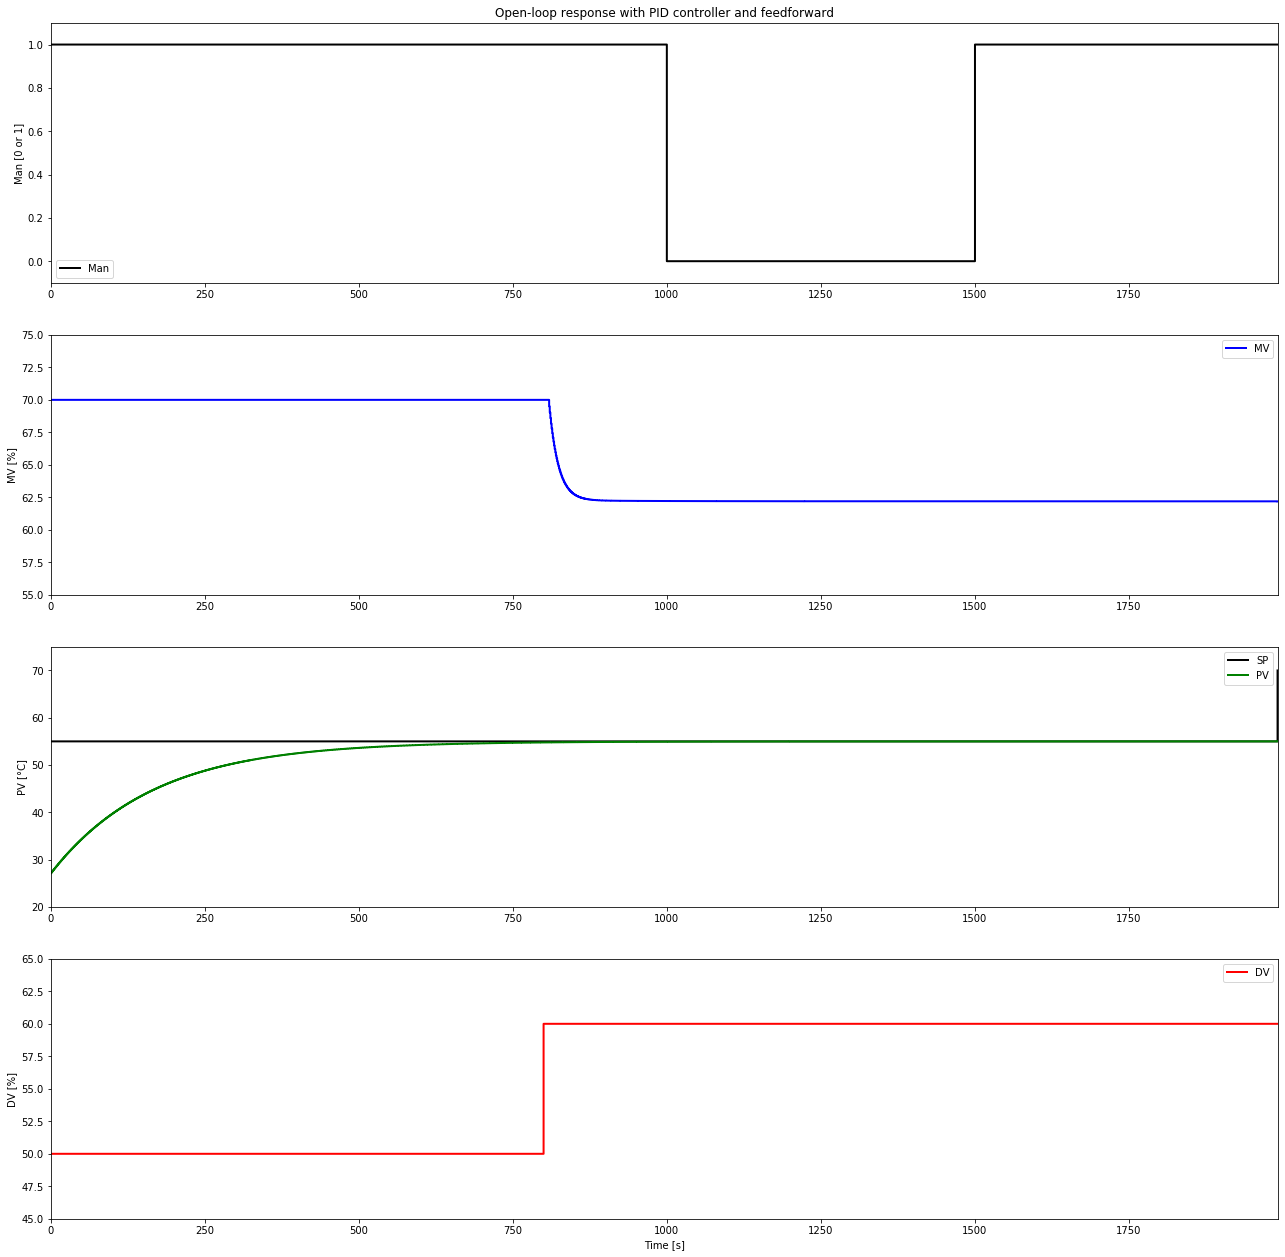

In [59]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1)
fig.set_figheight(22)
fig.set_figwidth(22)

l1, = ax1.step([0,t[-1]],[0,100],'k-',linewidth=2,label='Man',where='post')
ax1.set_ylabel('Man [0 or 1]')
ax1.set_title(Title_loop + ' response with PID controller and ' + Title_FF)
ax1.legend(loc='best')

l2, = ax2.step([0,t[-1]],[0,100],'b-',linewidth=2,label='MV',where='post')
ax2.set_ylabel('MV [%]')
ax2.legend(loc='best')

l3, = ax3.step([0,t[-1]],[0,100],'k-',linewidth=2,label='SP',where='post')

l4, = ax3.step([0,t[-1]],[0,100],'g-',linewidth=2,label='PV',where='post')
ax3.set_ylabel('PV [°C]')
ax3.legend(loc='best')

l5, = ax4.step([0,t[-1]],[0,100],'r-',linewidth=2,label='DV',where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('DV [%]')
ax4.legend(loc='best')

ManInt = [int(x) for x in Man]
l1.set_data(t,ManInt)
l2.set_data(t,MV)
l3.set_data(t,SP)
l4.set_data(t,PV)
l5.set_data(t,DV)

ax1.set_xlim(0,t[-1]+1)
ax2.set_xlim(0,t[-1]+1)
ax3.set_xlim(0,t[-1]+1)
ax4.set_xlim(0,t[-1]+1)

ax1.set_ylim(-0.1,1.1)
ax2.set_ylim(myRound(np.min(MV),5)-5,myRound(np.max(MV),5)+5)
ax3.set_ylim(myRound(np.min((np.min(PV),np.min(SP))),5)-5,myRound(np.max((np.max(PV),np.max(SP))),5)+5)
ax4.set_ylim(myRound(np.min(DV),5)-5,myRound(np.max(DV),5)+5)